<a href="https://colab.research.google.com/github/milanzongor/fault_detection_project/blob/master/fault_detection_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Sensor fault detection using machine learning

##Assignment
**47 Detekce poruch senzorů pomocí strojového učení B**

Navrhněte metodu pro detekci poruch senzorů (drift, offset, občasné
vychýlené hodnoty) s využitím dodaných dlouhých časových řad dat z
různých senzorů rodinného domu.

Data stáhněte z:
https://drive.google.com/drive/u/1/folders/1NuBf9n8XOYr_wH1IdUJoKNnhUJUvndSD

Označení sloupců rozkódujte pomocí možného významu dle přiloženého
souboru TXT. Prověřte, zda data neobsahují "impulsní" extrémní hodnoty,
výpadky a NaN, pokud ano, vyřaďte je nebo interpolujte. Jinak považujte
data za správná, tj. bez driftu a offsetu.

Můžete využít typické časové chování sinálů i vztahy mezi různými signály.

##Data description
Dataset contains measured data from House 11 is located in San Antonio, Texas. It has 42 features with 3810 values. Measurements were made once per hour since 7-15-2010 13:00:00 until 2010-12-21 04:00:00. It means that we have almoust half year of measured data. The measurements from this house include:

**Note**: Our data can be compared with historical data of weather (outside temperature, humidity) from website [https://www.wunderground.com/history/monthly/us/tx/harper/KSAT](https://www.wunderground.com/history/monthly/us/tx/harper/KSAT) and other similar sources.

**Water heater performance**:
Electricity use, temperature and volume of cold water entering, temperature and volume of hot water supplied by the water heater

- water_heater_electricity use of cold water
- water_heater_temp_cold - T_DHW_H_AVG
- water_heater_volume_cold
- water_heater_temp_hot - T_DHW_C_AVG
- water_heater_volume_hot

**HVAC system performance**:
Furnace natural gas use, air conditioner outdoor unit compressor and fan electricity use, air handler unit fan electricity use, temperature and RH at first and second floor thermostats, temperature and RH of outdoor air.

- furnace_gas_use - G_FURNACE_TOT
- ACU_outdoor_el_usage
- AHU_air_handler_fan_electricity - kWh_AHU 
- termostat_temp_1st - T_1ST_AVG
- termostat_rh_1st - RH_1ST_AVG
- termostat_temp_2nd - T_2ND_AVG
- termostat_rh_2nd - RH_2ND_AVG
- temp_out - T_Out_AVG
- rh_out - RH_Out_AVG

**Photovoltaic array performance**:
Electricity produced, electricity sold, incident solar radiation on the on the photovoltaic array

- photo_el_produced
- photo_el_sold
- photo_solar_radiation - R_SOLAR_AVG


##Coding part

###Imported libraries

In [0]:
!pip3 install --upgrade pip3 &> /dev/null
!pip3 install pandas --upgrade &> /dev/null

In [0]:
import pandas as pd
import numpy as np
from dateutil import parser, rrule
from datetime import datetime, time, date
import time
import seaborn as sn
import matplotlib.pyplot as plt
import matplotlib.dates as dates
# %matplotlib inline

from IPython.core.pylabtools import figsize
figsize(14, 10)

###Loading dataset

In [3]:
PROJECT_PATH = "/content/drive/My Drive/School/B3B38DIT/House_11_edit.csv"
df_raw = pd.read_csv(PROJECT_PATH)

df_raw.drop(['Year_RTM.1', 'Day_RTM.1', 'Hour_Minute_RTM.1', 'PrgSig.1', 'VBatt.1'], axis=1, inplace=True)

for feature in df_raw.columns:
  if df_raw[feature].dtype == "int64":
    df_raw[feature] = df_raw[feature].astype(float)

# print information about dataset and show the first 5 rows
print(df_raw.info())
display(df_raw.head(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3810 entries, 0 to 3809
Data columns (total 37 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Year_RTM         3810 non-null   float64
 1   Day_RTM          3810 non-null   float64
 2   Hour_Minute_RTM  3810 non-null   float64
 3   Datetime         3810 non-null   object 
 4   PrgSig           3810 non-null   float64
 5   VBatt            3810 non-null   float64
 6   R_SOLAR_AVG      3810 non-null   float64
 7   T_Out_AVG        3810 non-null   float64
 8   T_1ST_AVG        3810 non-null   float64
 9   T_2ND_AVG        3810 non-null   float64
 10  T_DHW_C_AVG      2779 non-null   float64
 11  T_DHW_H_AVG      2779 non-null   float64
 12  RH_Out_AVG       3810 non-null   float64
 13  RH_1ST_AVG       3810 non-null   float64
 14  RH_2ND_AVG       3810 non-null   float64
 15  I_DHWa_AVG       3810 non-null   float64
 16  I_DHWb_AVG       3810 non-null   float64
 17  I_Solpmp_AVG  

,Year_RTM,Day_RTM,Hour_Minute_RTM,Datetime,PrgSig,VBatt,R_SOLAR_AVG,T_Out_AVG,T_1ST_AVG,T_2ND_AVG,T_DHW_C_AVG,T_DHW_H_AVG,RH_Out_AVG,RH_1ST_AVG,RH_2ND_AVG,I_DHWa_AVG,I_DHWb_AVG,I_Solpmp_AVG,I_FirePl_AVG,RT_AHU_AVG,RT_CMP_AVG,kWh_DHWa_TOT,kWh_DHWb_TOT,WH_AHU_TOT,KWH_CMP_TOT,KWH_TANK_TOT,WH_SPMP_TOT,KWH_AMEL_TOT,KWH_Light_TOT,KWH_PV_P_TOT,KWH_PV_S_TOT,KWH_NET_TOT,KWH_HOUSE_TOT,Q_DWH_FSH_TOT,G_FURNACE_TOT,TE_DHWtnk_TOT,kWh_AHU
0,2010.0,196.0,1300.0,7/15/2010 13:00,5268.0,13.25,555.9,86.8,75.1,75.0,NaN,NaN,59.83,37.94,41.50,17.550,17.620,0.339,0.007,1.0,1.0,0.392,0.393,17.58,0.299,0.785,0.0,0.0,0.231,0.0,0.0,1.458,1.458,0.0,0.0,0.0,0.01758
1,2010.0,196.0,1400.0,7/15/2010 14:00,5268.0,13.25,-6999.0,88.4,75.0,75.3,NaN,NaN,55.66,37.20,40.34,11.500,11.530,0.339,0.007,1.0,1.0,1.379,1.384,98.40,1.587,2.763,0.0,0.0,1.447,0.0,0.0,6.358,6.358,0.0,0.0,0.0,0.09840
2,2010.0,196.0,1500.0,7/15/2010 15:00,5268.0,13.25,-6999.0,91.6,74.9,75.0,NaN,NaN,49.15,36.26,38.97,0.009,0.022,0.331,0.008,1.0,1.0,0.001,0.003,226.70,2.405,0.004,0.0,0.0,1.359,0.0,0.0,4.253,4.253,0.0,0.0,0.0,0.22670
3,2010.0,196.0,1600.0,7/15/2010 16:00,5268.0,13.24,701.0,92.7,74.8,75.1,NaN,NaN,46.31,35.37,39.24,0.013,0.027,0.326,0.008,1.0,1.0,0.002,0.003,243.00,2.496,0.005,0.0,0.0,1.322,0.0,0.0,4.310,4.310,0.0,0.0,0.0,0.24300
4,2010.0,196.0,1700.0,7/15/2010 17:00,5268.0,13.24,615.4,93.5,75.0,75.0,NaN,NaN,44.00,35.85,38.86,0.013,0.027,0.321,0.008,1.0,1.0,0.002,0.003,227.30,2.502,0.005,0.0,0.0,1.333,0.0,0.0,4.303,4.303,0.0,0.0,0.0,0.22730


###Data cleaning


####Missing data
Firstly, I am going to check if our dataset is missing any values of data (null, nan). Our dataset contains 3810 values. We can see that three features are missing significant number of data.
- T_DHW_C_AVG          1031
- T_DHW_H_AVG          1031
- kWh_AHU              1993

We can see that these columns are missing 27-52% of the data. If the percentage would be smaller we could use differnt techniques to fix the missing data (e.g. median). In our case is the drop off significant, that is why I decided to drop these three columns.

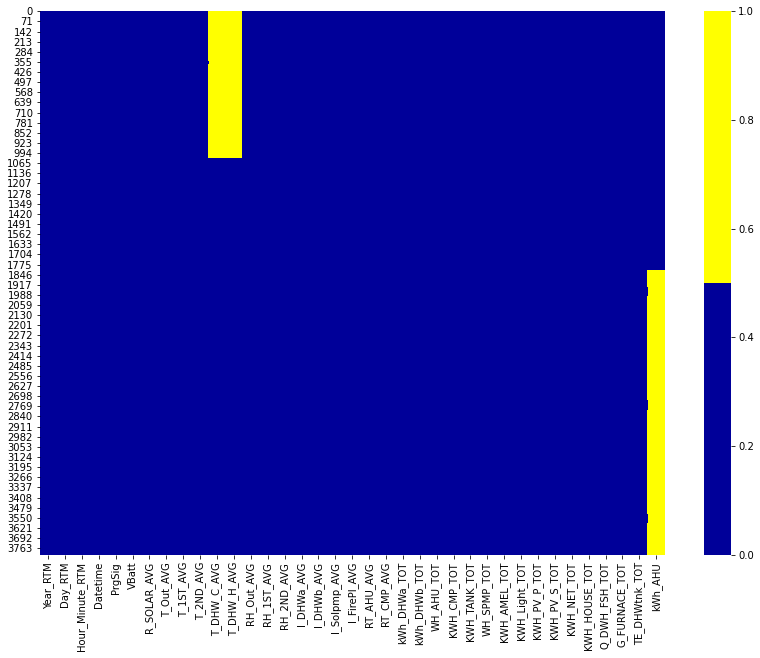

In [4]:
cols = df_raw.columns[:]
colours = ['#000099', '#ffff00'] # yellow is missing. blue is not missing.
sn.heatmap(df_raw[cols].isnull(), cmap=sn.color_palette(colours));

In [5]:
# Count of null cells in each column for the raw dataset
null_counts = df_raw.isnull().sum()
print("Number of null values in each column:\n{}".format(null_counts))

print("\nPercentage of missing data in columns:")
for col in df_raw.columns:
    pct_missing = np.mean(df_raw[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing*100)))

Number of null values in each column:
Year_RTM              0
Day_RTM               0
Hour_Minute_RTM       0
Datetime              0
PrgSig                0
VBatt                 0
R_SOLAR_AVG           0
T_Out_AVG             0
T_1ST_AVG             0
T_2ND_AVG             0
T_DHW_C_AVG        1031
T_DHW_H_AVG        1031
RH_Out_AVG            0
RH_1ST_AVG            0
RH_2ND_AVG            0
I_DHWa_AVG            0
I_DHWb_AVG            0
I_Solpmp_AVG          0
I_FirePl_AVG          0
RT_AHU_AVG            0
RT_CMP_AVG            0
kWh_DHWa_TOT          0
kWh_DHWb_TOT          0
WH_AHU_TOT            0
KWH_CMP_TOT           0
KWH_TANK_TOT          0
WH_SPMP_TOT           0
KWH_AMEL_TOT          0
KWH_Light_TOT         0
KWH_PV_P_TOT          0
KWH_PV_S_TOT          0
KWH_NET_TOT           0
KWH_HOUSE_TOT         0
Q_DWH_FSH_TOT         0
G_FURNACE_TOT         0
TE_DHWtnk_TOT         0
kWh_AHU            1993
dtype: int64

Percentage of missing data in columns:
Year_RTM - 0.0%
Day_R

####Unnecessary data

#####Uninformative / Repetitive
Secondly I tried to look for the rows, which has low information value or are highly repetitive. If the feature has more than 95% of the rows the same value, highlight it. 

We can see that columns [Year_RTM, Year_RTM.1, WH_SPMP_TOT, KWH_AMEL_TOT, G_FURNACE_TOT] have highly repetitive content. We should consider not using these columns in our further research. We can also observe that some columns might be duplicated in our original dataset e.g. [Year_RTM, Year_RTM.1].

In [6]:
num_rows = len(df_raw.index)
low_information_cols = [] #

for col in df_raw.columns:
    cnts = df_raw[col].value_counts(dropna=False)
    top_pct = (cnts/num_rows).iloc[0]
    
    if top_pct > 0.95:
        low_information_cols.append(col)
        print('{0}: {1:.5f}%'.format(col, top_pct*100))
        print(cnts)
        print()

df_raw.drop(['Year_RTM', 'KWH_AMEL_TOT', 'WH_SPMP_TOT', 'G_FURNACE_TOT'], axis=1, inplace=True)

Year_RTM: 100.00000%
2010.0    3810
Name: Year_RTM, dtype: int64

WH_SPMP_TOT: 100.00000%
0.0    3810
Name: WH_SPMP_TOT, dtype: int64

KWH_AMEL_TOT: 100.00000%
0.0    3810
Name: KWH_AMEL_TOT, dtype: int64

G_FURNACE_TOT: 97.74278%
0.0     3724
22.0       8
24.0       7
23.0       6
26.0       6
21.0       5
25.0       5
13.0       4
8.0        4
9.0        4
28.0       3
29.0       3
17.0       3
14.0       2
4.0        2
35.0       2
19.0       2
20.0       2
18.0       2
12.0       2
27.0       2
30.0       2
69.0       1
5.0        1
10.0       1
15.0       1
32.0       1
2.0        1
7.0        1
6.0        1
1.0        1
33.0       1
Name: G_FURNACE_TOT, dtype: int64



#####Drop data columns
From previous two sections, we can see that we shouldn't consider using at least 8 features of our provided dataset. However, after ploting the data, I decided to do the analysis with the temperature and relative humidity data, which looks interesting for further work. That is why I am going to drop other columns from dataset.

I still kept the raw dataset stored in the variable df_raw and creted new one df containing these columns : ['Datetime', 'T_Out_AVG', 'T_1ST_AVG', 'T_2ND_AVG', 'RH_1ST_AVG', 'RH_2ND_AVG'].

In [7]:
columns_to_keep = ['Datetime', 'T_Out_AVG', 'T_1ST_AVG', 'T_2ND_AVG', 'RH_1ST_AVG', 'RH_2ND_AVG']
df = df_raw[columns_to_keep]
df.head(5)

,Datetime,T_Out_AVG,T_1ST_AVG,T_2ND_AVG,RH_1ST_AVG,RH_2ND_AVG
0,7/15/2010 13:00,86.8,75.1,75.0,37.94,41.50
1,7/15/2010 14:00,88.4,75.0,75.3,37.20,40.34
2,7/15/2010 15:00,91.6,74.9,75.0,36.26,38.97
3,7/15/2010 16:00,92.7,74.8,75.1,35.37,39.24
4,7/15/2010 17:00,93.5,75.0,75.0,35.85,38.86


In [8]:
df.dtypes

Datetime       object
T_Out_AVG     float64
T_1ST_AVG     float64
T_2ND_AVG     float64
RH_1ST_AVG    float64
RH_2ND_AVG    float64
dtype: object

####Inconsistent data
It is also crucial to have the dataset follow specific standards to fit a model.

#####Format inconsistency
I need to perform a standardization of the data formats. All our features, except datetime, are in float format. The float format makes sence for the temperature and RH values. The datetime feature has object value - it's format was not recognized by Pandas library and would cause difficulties in the future work. So I need to perform the transformation to datetime format.

In [9]:
print("Formats of dataset features")
df.dtypes

Formats of dataset features


Datetime       object
T_Out_AVG     float64
T_1ST_AVG     float64
T_2ND_AVG     float64
RH_1ST_AVG    float64
RH_2ND_AVG    float64
dtype: object

In [0]:
df.Datetime = pd.to_datetime(df.Datetime)

# df.loc['Datetime'] = pd.to_datetime(df.Datetime)
# dt = df.loc[1, "Datetime"]
# print(dt.month, dt.year, dt.day, dt.hour, dt.minute, dt.second)

In [11]:
print("Formats of dataset features")
df.dtypes

Formats of dataset features


Datetime      datetime64[ns]
T_Out_AVG            float64
T_1ST_AVG            float64
T_2ND_AVG            float64
RH_1ST_AVG           float64
RH_2ND_AVG           float64
dtype: object

In [0]:
# It is also handy to set the Datetime feature as an index of our dataset.
# df.index = df.Datetime
# df.drop('Datetime', axis=1, inplace=True)

####Irregular data (outliers)
It is also crucial to get rid of the wrongly measured data. Sometimes sensor got stuck in some state and the output is suddenly shifted by some value or stuck in the edge min/max values. These wrong values, outliers, must be replaced.

#####Plot check

There are many techniques in order to get rid of them. At first, it is good to visualise data and try to see if there aren't any significant jumps or peaks.


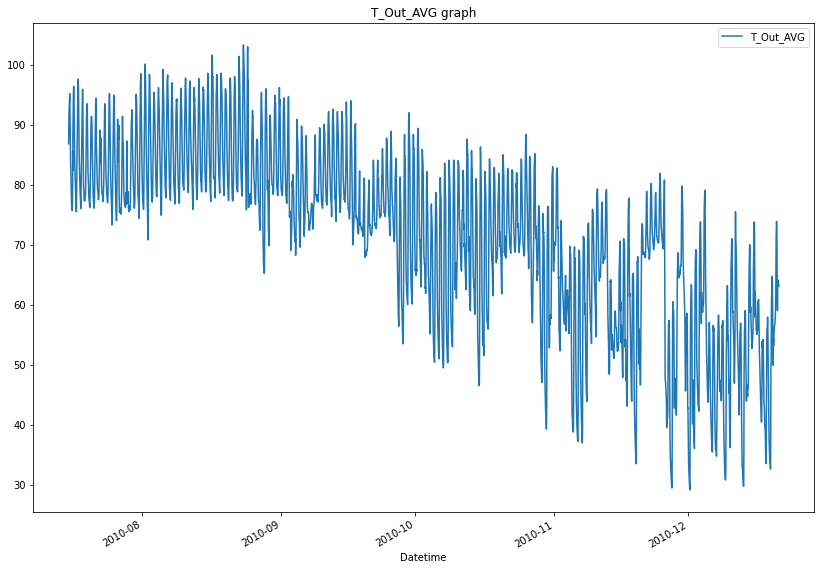

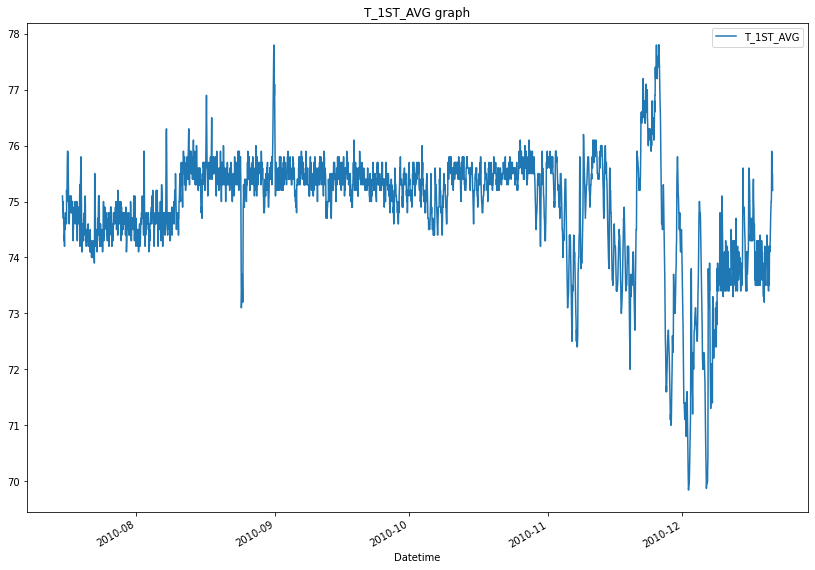

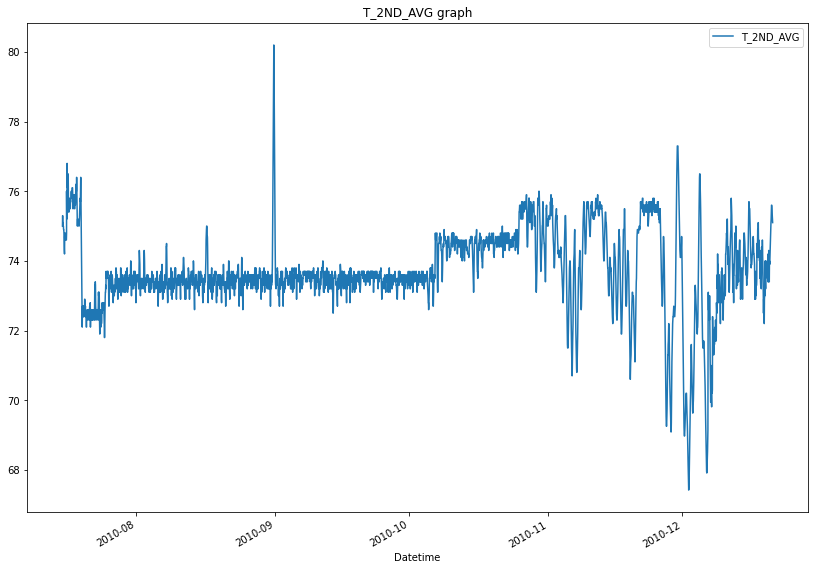

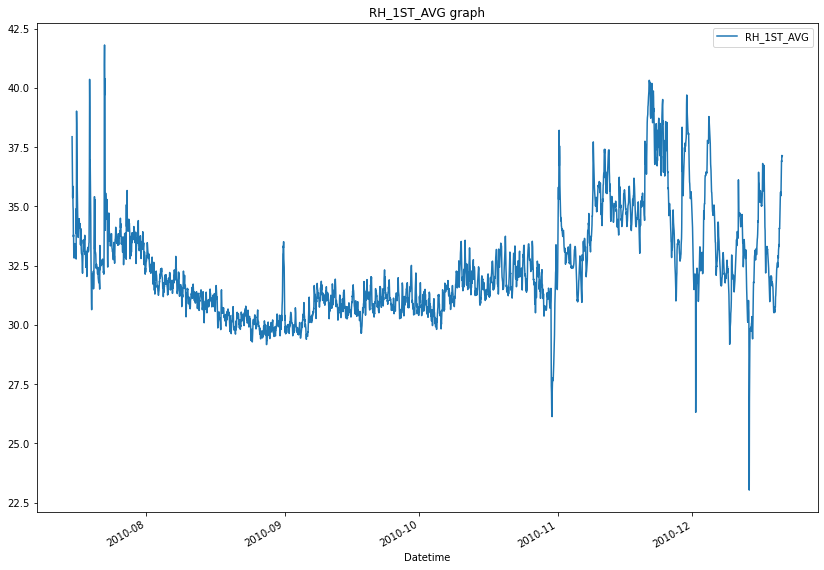

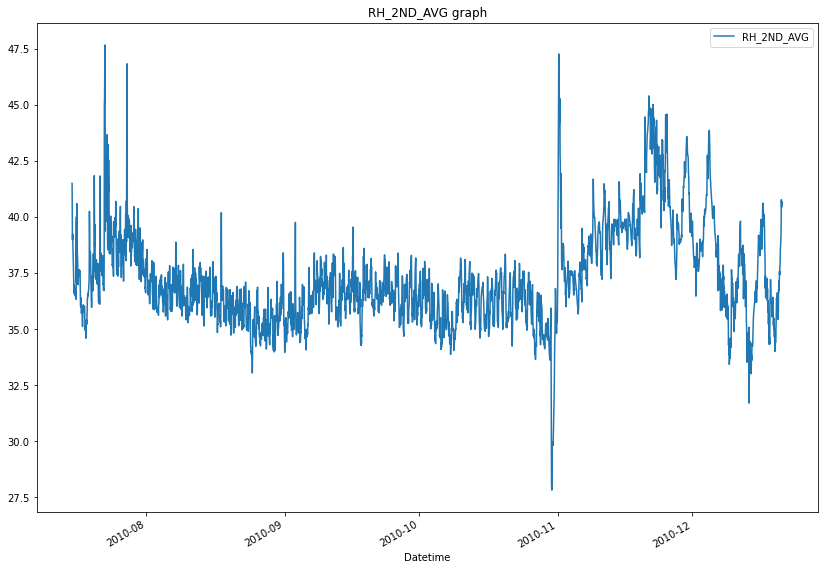

In [13]:
for feature in df.columns:
  if feature != 'Datetime':
    df.plot(x="Datetime", y=feature, title=feature + " graph")

# for feature in df.columns:
#     df.reset_index().plot(x='Datetime', y=feature, title=feature + " graph")
#     plt.ylabel(feature)

#####Histogram/Box Plot

Plotting histogram is a good technique to see the distribution of the data. We can also see the range of data. If the range would be suspicious e.g. temperature over 120 Farenheit or RH not in range <0,100> we can quickly recognize it and fix it or investigate the feature more.

**Note**: In this notebook I print only the T_Out_AVG values in order to demonstrate the teqchnique. I plotted graphs of every feature for my personal understanding, but it uses a lot of space. Other values can be easily printed just be changing the feature variable.

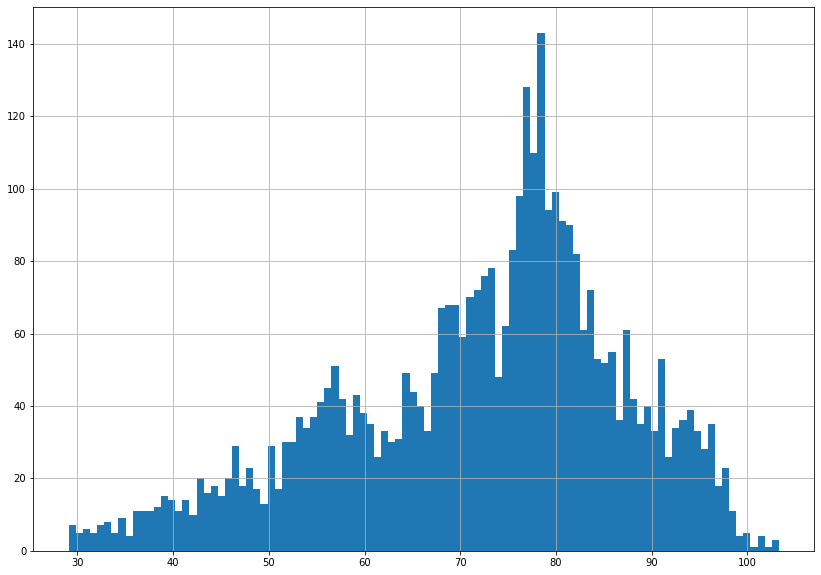

In [14]:
#['T_Out_AVG', 'T_1ST_AVG', 'T_2ND_AVG', 'RH_1ST_AVG', 'RH_2ND_AVG']
features_list = df.columns

feature = 'T_Out_AVG'
df[feature].hist(bins=100);

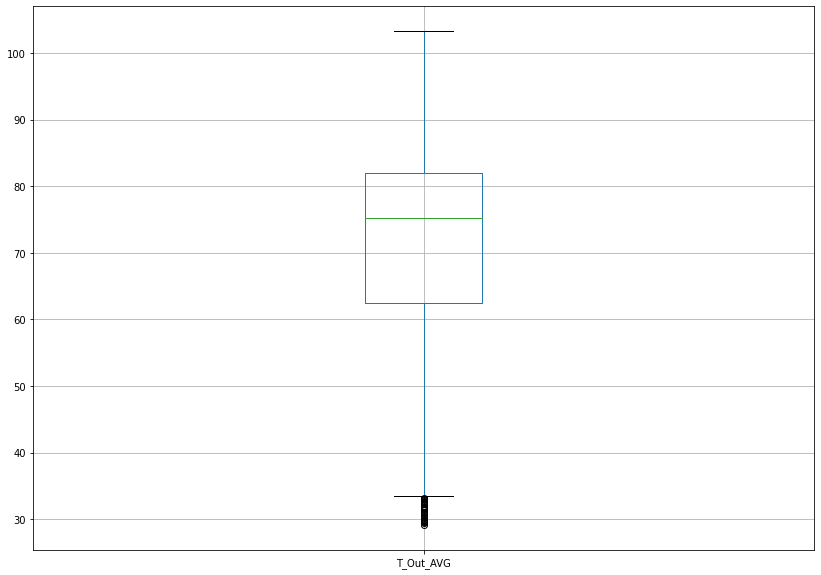

In [15]:
df.boxplot(column=[feature]);

#####Descriptive Statistics
For numeric features, the outliers could be too distinct that the box plot can’t visualize them. Instead, we can look at their descriptive statistics. For furthure example we can see that the values are in expected range for the outside temperature values in San Antonio.

In [16]:
df[feature].describe()

count    3810.000000
mean       72.016194
std        14.880829
min        29.090000
25%        62.480000
50%        75.200000
75%        81.975000
max       103.300000
Name: T_Out_AVG, dtype: float64

####Smoothing the data
I tried different approaches for smoothing the data. However the rolling median worked the best. To set the smoothing correctly we need to adjust the window size parameter and number of periods.

Big size of window will smooth also outliers which lasted many hours. On the other hand it will delete the character of data in the short periods, which is especially necessary to keep for our NN. I tried different settings and this one looks to work the best. It will smooth the single outliers. I plotted the 1st floor temperature for raw and smoothed data. It still looks like having some outliers. But in deeper investigation the higher/lower values are long-term and in good range.

In [0]:
for feature in df.columns:
  if feature != 'Datetime':
    df[feature] = df[feature].rolling(window=3, center=True, min_periods=1).median()

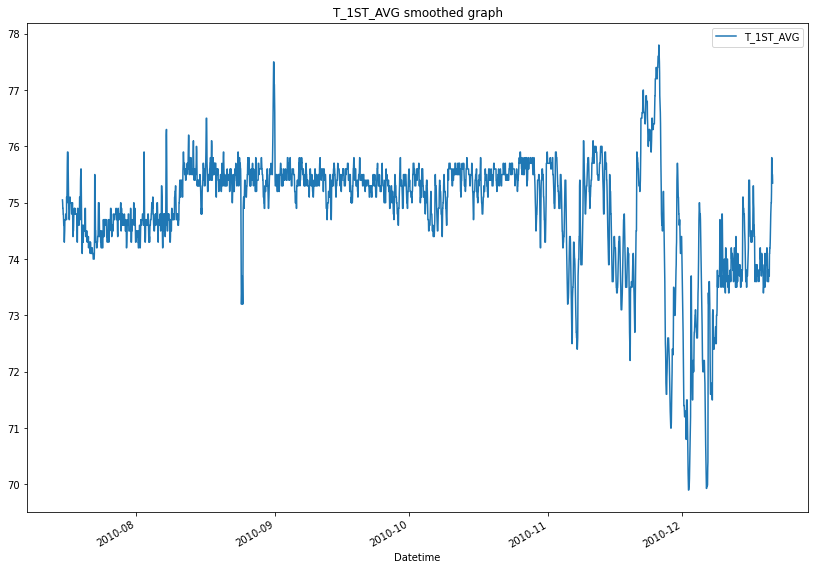

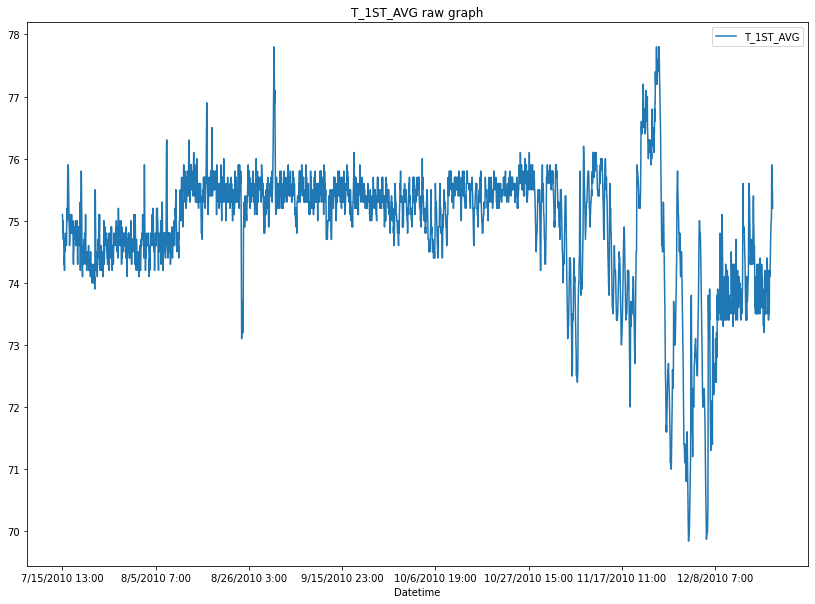

In [18]:
feature = "T_1ST_AVG"

df.plot(x='Datetime', y=feature, title=feature + " smoothed graph");
df_raw.plot(x='Datetime', y=feature, title=feature + " raw graph");

###Associations
In this chapter I am going to try to find some associations among the data even before using the LSTM neural network. I will be using correlation, trend line and other methods to understand our data even better.

####Correlation
Firstly I tried to see the correlation matrix for the raw dataset - all values. This matrix has dimenstions of 33x33 and is not good readable. 
Underneath is placed the correlation matrix with our cleaned dataset. The values of correlation are in range <-0.3; 1>. There is not significant negative correlation. However we can see there two significant positive correlations. There is correlation 0.9 between values RH_1ST_AVG and RH_2ND_AVG. And the correlation 0.73 between T_1ST_AVG and T_2ND_AVG. We can see that the values are closely connected together. This correlation is probably caused by the AC unit for the house.

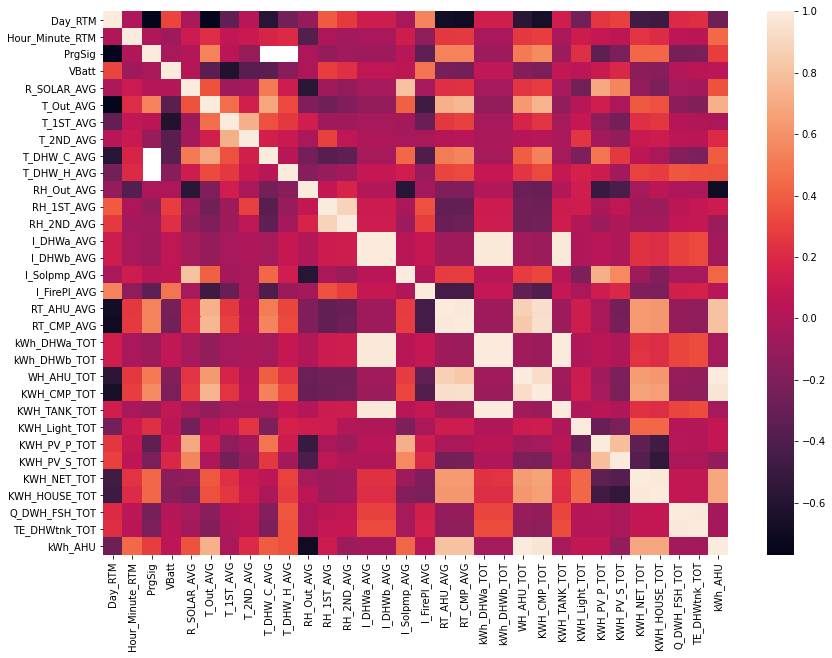

In [19]:
corr_matrix = df_raw.corr()
sn.heatmap(corr_matrix, annot=False)
plt.show()

In [20]:
corr_matrix = df_raw.corr()
sol = (corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
                 .stack()
                 .sort_values(ascending=False))
print(sol)

WH_AHU_TOT    kWh_AHU         1.000000
kWh_DHWa_TOT  KWH_TANK_TOT    0.999998
kWh_DHWb_TOT  KWH_TANK_TOT    0.999998
I_DHWa_AVG    I_DHWb_AVG      0.999997
kWh_DHWa_TOT  kWh_DHWb_TOT    0.999995
                                ...   
Day_RTM       RT_AHU_AVG     -0.680542
              RT_CMP_AVG     -0.696079
RH_Out_AVG    kWh_AHU        -0.698332
Day_RTM       T_Out_AVG      -0.751494
              PrgSig         -0.769475
Length: 494, dtype: float64


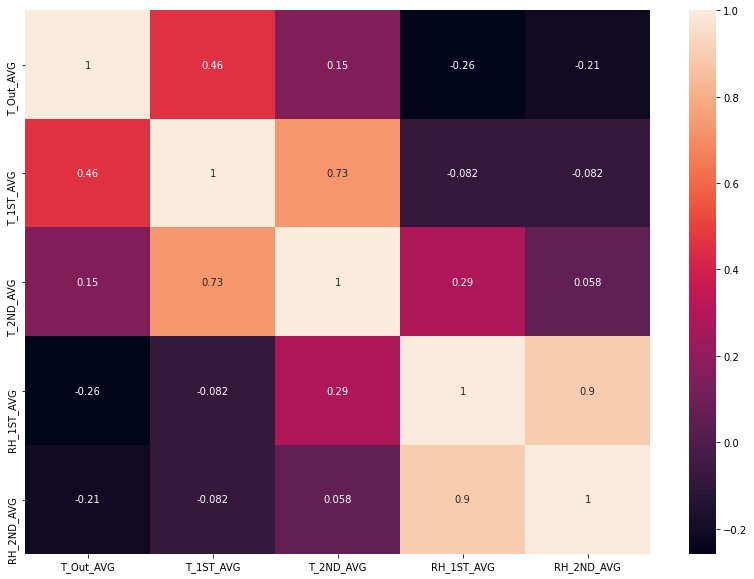

In [21]:
corr_matrix = df.corr()
sn.heatmap(corr_matrix, annot=True)
plt.show()

####Trend line
In order to understand the data better I am going to print the trend line for temperature and the RH. As mentioned before this dataset contains data in the time period from July 2010 to December 2010. 

According to the trend line we can see that the temperature inside tried to be kept in the same range. However the relative humidity had increasing trend. It can be caused by more humid weather and more rainy days in San Antonio, TX during the winter. This idea is supported also by the [USA national weather history for San Antonio](https://weather-and-climate.com/average-monthly-Rainfall-Temperature-Sunshine-fahrenheit,san-antonio-texas-us,United-States-of-America). However I have to admit, that the AC unit has significant effect in decreacing the humidity in the inside air. 
The outside temperature has decreasing trend as the winter is coming and San Antonio is located in the Northern Hemisphere. 

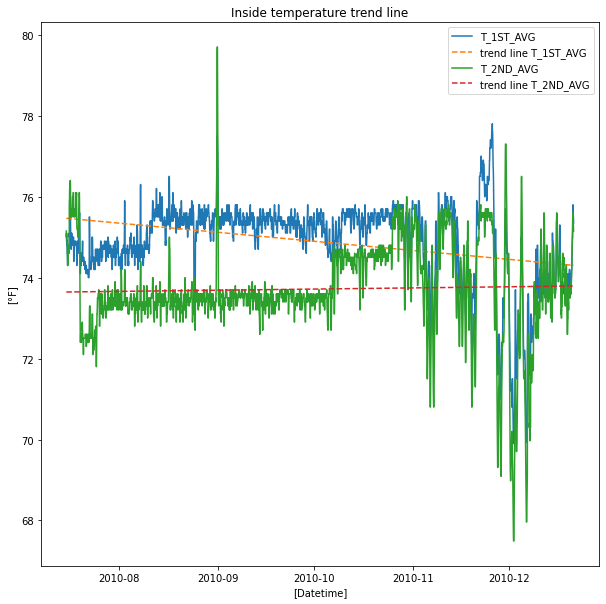

In [22]:
features_to_plot = ['T_1ST_AVG', 'T_2ND_AVG']

x = dates.date2num(df.Datetime)
plt.figure(figsize=(10, 10))

for feature in features_to_plot:
  y = df[feature]
  plt.plot(x, y, label=feature)
  z = np.polyfit(x, y, 1)
  p = np.poly1d(z)
  plt.plot_date(x,p(x),"--", label="trend line " + feature)

plt.legend(loc="best")
plt.title("Inside temperature trend line")
plt.xlabel("[Datetime]")
plt.ylabel("[°F]");

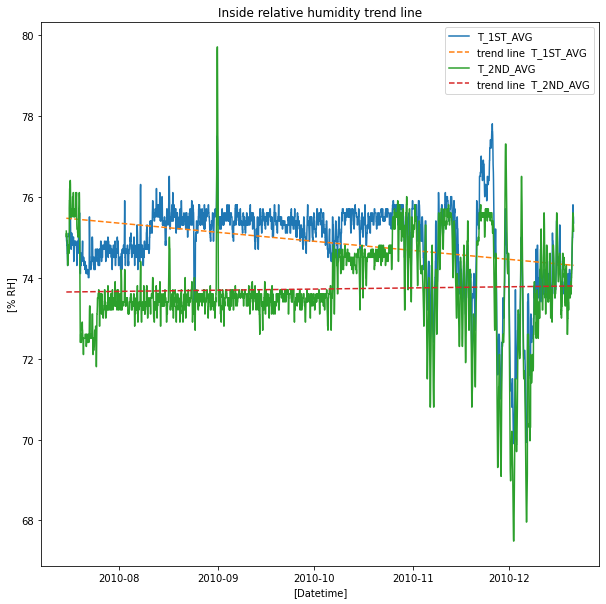

In [23]:
Dafeatures_to_plot = ['RH_1ST_AVG', 'RH_2ND_AVG']

x = dates.date2num(df.Datetime)
plt.figure(figsize=(10, 10))

for feature in features_to_plot:
  y = df[feature]
  plt.plot(x, y, label=feature)
  z = np.polyfit(x, y, 1)
  p = np.poly1d(z)
  plt.plot_date(x,p(x),"--", label="trend line  " + feature)

plt.legend(loc="best")
plt.title("Inside relative humidity trend line")
plt.xlabel("[Datetime]")
plt.ylabel("[% RH]");

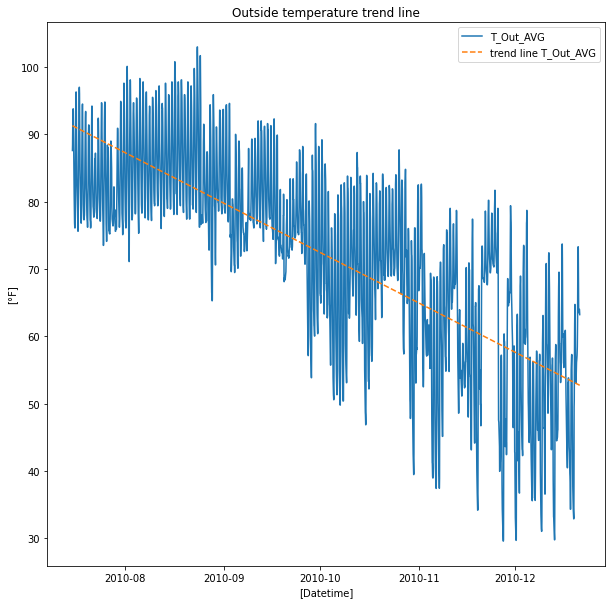

In [24]:
feature = 'T_Out_AVG'

plt.figure(figsize=(10, 10))
x = dates.date2num(df.Datetime)
y = df[feature]
plt.plot(x, y, label=feature)
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot_date(x,p(x),"--", label="trend line " + feature)

plt.legend(loc="best")
plt.title("Outside temperature trend line")
plt.xlabel("[Datetime]")
plt.ylabel("[°F]");

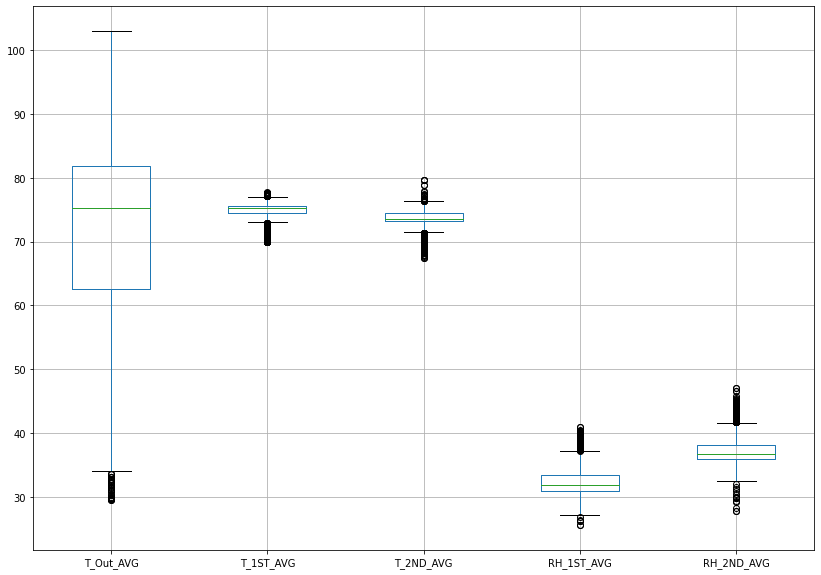

In [25]:
df.boxplot();

####Time values
I added columns for hours, daylight, day of the week and working day. These columns should help the neural network to recognize paterns better.

In [0]:
#Formating the data into required format
df['hours'] = df['Datetime'].dt.hour
df['daylight'] = ((df['hours'] >= 7) & (df['hours'] <= 22)).astype(int)
df['DayOfTheWeek'] = df['Datetime'].dt.dayofweek
df['WeekDay'] = (df['DayOfTheWeek'] < 5).astype(int)

####Fault dataset
In this section I am going to create error dataset. I will add different types of errors, offsets and noise the data.

As we could see that the RH and temperature on both floors are highly positive correlated. That is why I added error only to one of the them. Then the model can easily recognize, that at least one of the sensors isn't working correnctly. 
I added offset, linear rising error and quadratic rising error with Gaussian noise.

In [0]:
df_err = df.copy()
df_err.head(5)

division = df_err.shape[0]//10
print(division)

temp_offset = 10.0
hum_offset = 10.0

i = 0
df_err.T_1ST_AVG[i*division:(i+1)*division] = df_err.T_1ST_AVG[i*division:(i+1)*division] + temp_offset

i = 1
df_err.T_1ST_AVG[i*division:(i+1)*division] = df_err.T_1ST_AVG[i*division:(i+1)*division] - temp_offset

i = 2
df_err.RH_1ST_AVG[i*division:(i+1)*division] = df_err.RH_1ST_AVG[i*division:(i+1)*division] + hum_offset

i = 3
df_err.RH_1ST_AVG[i*division:(i+1)*division] = df_err.RH_1ST_AVG[i*division:(i+1)*division] - hum_offset

i = 4
error_list = np.linspace(0.0, 20, num=division)
df_err.RH_1ST_AVG[i*division:(i+1)*division] = df_err.RH_1ST_AVG[i*division:(i+1)*division] - error_list

i = 5
error_list = np.linspace(0.0, 20, num=division)
df_err.RH_2ND_AVG[i*division:(i+1)*division] = df_err.RH_2ND_AVG[i*division:(i+1)*division] + error_list

i = 6
error_list = np.linspace(0.0, 20, num=division)
df_err.T_1ST_AVG[i*division:(i+1)*division] = df_err.T_1ST_AVG[i*division:(i+1)*division] - error_list

i = 7
error_list = np.linspace(0.0, 20, num=division)
df_err.T_1ST_AVG[i*division:(i+1)*division] = df_err.T_1ST_AVG[i*division:(i+1)*division] + error_list

i = 8
error_list = np.linspace(0.0, 4, num=division)
error_list = [2**num for num in error_list]
noise = np.random.normal(0, 0.5,division)
error_list = error_list + noise
df_err.T_1ST_AVG[i*division:(i+1)*division] = df_err.T_1ST_AVG[i*division:(i+1)*division] + error_list

i = 9
error_list = np.linspace(0.0, 4, num=division)
error_list = [2**num for num in error_list]
noise = np.random.normal(0, 0.5,division)
error_list = error_list + noise
df_err.T_2ND_AVG[i*division:(i+1)*division] = df_err.T_2ND_AVG[i*division:(i+1)*division] - error_list



In [0]:
# label the columns
df['label'] = pd.Series(1, index=df.index)
df_err['label'] = pd.Series(0, index=df.index)

In [29]:
df = pd.concat([df, df_err])
df.head(5)

,Datetime,T_Out_AVG,T_1ST_AVG,T_2ND_AVG,RH_1ST_AVG,RH_2ND_AVG,hours,daylight,DayOfTheWeek,WeekDay,label
0,2010-07-15 13:00:00,87.6,75.05,75.15,37.57,40.92,13,1,3,1,1
1,2010-07-15 14:00:00,88.4,75.00,75.00,37.20,40.34,14,1,3,1,1
2,2010-07-15 15:00:00,91.6,74.90,75.10,36.26,39.24,15,1,3,1,1
3,2010-07-15 16:00:00,92.7,74.90,75.00,35.85,38.97,16,1,3,1,1
4,2010-07-15 17:00:00,93.5,74.80,75.00,35.37,38.86,17,1,3,1,1


###Model

In [30]:
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Setting seed for reproducibility
np.random.seed(1234)  
PYTHONHASHSEED = 0

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, LSTM

# define path to save model
model_path = PROJECT_PATH + 'binary_model.h5'

Using TensorFlow backend.


In [0]:
df.drop('Datetime', axis=1, inplace=True)
cols_to_norm = df.columns
df[cols_to_norm] = df[cols_to_norm].apply(lambda x: (x - x.min()) / (x.max() - x.min()))

In [0]:
def lstm_data_transform(x_data, y_data, num_steps):
    """ Changes data to the format for LSTM training 
    for sliding window approach """    
    # Prepare the list for the transformed data
    X, y = list(), list()    
    
    # Loop of the entire data set
    for i in range(x_data.shape[0]):
        # compute a new (sliding window) index
        end_ix = i + num_steps        
        
        # if index is larger than the size of the dataset, we stop
        if end_ix >= x_data.shape[0]:
            break        
            
        # Get a sequence of data for x
        seq_X = x_data[i:end_ix]
        
        # Get only the last element of the sequency for y
        seq_y = y_data[end_ix]        
        
        # Append the list with sequencies
        X.append(seq_X)
        y.append(seq_y)    
        
    # Make final arrays
    x_array = np.array(X)
    y_array = np.array(y)    
    return x_array, y_array

sequence_length = 24

y_data = df.label.values
x_data = df.drop('label', axis=1).values

seq_array, label_array = lstm_data_transform(x_data, y_data, sequence_length)

nb_features = seq_array.shape[2]
nb_out = 1

In [44]:
batch_sz = 240

model = Sequential()

model.add(LSTM(
         input_shape=(sequence_length, nb_features),
         units=50,
         return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(
          units=25,
          return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units=nb_out, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

# fit the network
history = model.fit(seq_array, label_array, epochs=10, batch_size=batch_sz, validation_split=0.2, verbose=2,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                       keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
          )

# list all data in history
print(history.history.keys())

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_15 (LSTM)               (None, 24, 50)            12000     
_________________________________________________________________
dropout_15 (Dropout)         (None, 24, 50)            0         
_________________________________________________________________
lstm_16 (LSTM)               (None, 25)                7600      
_________________________________________________________________
dropout_16 (Dropout)         (None, 25)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 26        
Total params: 19,626
Trainable params: 19,626
Non-trainable params: 0
_________________________________________________________________
None
Train on 6076 samples, validate on 1520 samples
Epoch 1/10
 - 2s - loss: 0.6449 - accuracy: 0.6396 - val_loss: 

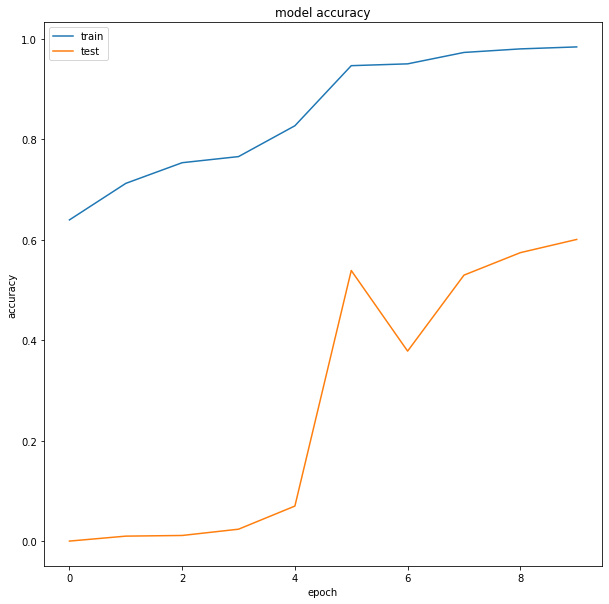

7596/7596 [==============================] - 1s 70us/step
Accurracy: 0.9054765701293945
7596/7596 [==============================] - 1s 82us/step
Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels
[[3105  705]
 [  13 3773]]
precision =  0.8425636444841447 
 recall =  0.996566296883254


In [45]:
# summarize history for Accuracy
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("model_accuracy.png")

# training metrics
scores = model.evaluate(seq_array, label_array, verbose=1, batch_size=batch_sz)
print('Accurracy: {}'.format(scores[1]))

# make predictions and compute confusion matrix
y_pred = model.predict_classes(seq_array,verbose=1, batch_size=batch_sz)
y_true = label_array

test_set = pd.DataFrame(y_pred)
test_set.to_csv('binary_submit_train.csv', index = None)

print('Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
cm = confusion_matrix(y_true, y_pred)
print(cm)

# compute precision and recall
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
print( 'precision = ', precision, '\n', 'recall = ', recall)

####Conclusion
In this project, I tried to implement fault detection using recurent neural network. From different approaches I have choosen the binary classification. After the data cleaning, the choosen data were considered as right and labeled with 1. Then I created the error/fault data. At the beginning I generated 10-times more error data than the correct data. However, this caused that the NN was learnt more for error data and could not classify the corrent ones. That is why I decided to have the same amount of correct and error data. I coppied correct dataset, divided it into 10 parts and added different types of linear and quadratic errors with noise and offsets.

Then I trained neural network with different setups. The results were better, but still not satisfying. My neural network has the overfitting problem. After I tried the hyperparameter tuning I was able to reach really high training accuracy (\~90%) and quite high validation accuracy (\~60%). However the validation error was not decreasing. 

That is why, I think that the whole approach of fault detection by binary classification is not correct. For further fault detection analysis, I would recommend to use the LSTM predictive model and then the anomaly detection in order to detect measured errors. However this approach would need more measured data.

To conclude, even though I performed data cleaning, smoothing, normalization and visualization, the binary classification is not correct approach in for this dataset and this kind of problem.

###PDF creation

In [0]:
!apt-get install texlive texlive-xetex texlive-latex-extra pandoc &> /dev/null
!pip install pypandoc &> /dev/null

In [0]:
!jupyter nbconvert --to PDF "/content/drive/My Drive/Colab Notebooks/fault_detection_project.ipynb" &> /dev/null

##Sources
[Weather station analysis](https://www.shanelynn.ie/analysis-of-weather-data-using-pandas-python-and-seaborn/)

[Data clening guide](https://towardsdatascience.com/data-cleaning-in-python-the-ultimate-guide-2020-c63b88bf0a0d)

[Removing outlayers](https://towardsdatascience.com/ways-to-detect-and-remove-the-outliers-404d16608dba)

[3 ways to remove outlayers](https://ocefpaf.github.io/python4oceanographers/blog/2015/03/16/outlier_detection/)

[Predictive maintanance using LSTM](https://github.com/umbertogriffo/Predictive-Maintenance-using-LSTM)

[Understanding LSTM Networks](http://colah.github.io/posts/2015-08-Understanding-LSTMs/)

[Fault detection using LSTM](https://www.arxiv-vanity.com/papers/1612.06676/)

[Time series forecasting - tutorial Tensorflow](https://www.tensorflow.org/tutorials/structured_data/time_series)

[Anomaly Detection in Temperature Sensor Data using LSTM RNN Model](https://analyticsindiamag.com/anomaly-detection-in-temperature-sensor-data-using-lstm-rnn-model/)
